In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools

%matplotlib inline
%config Completer.use_jedi = False

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


sns.set(style="whitegrid", color_codes=True)
sns.set_context("paper")

sns.set(style="whitegrid", color_codes=True)
color_blind = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
divert_color = ['#a6611a','#dfc27d','#f5f5f5','#80cdc1','#018571']

In [2]:
# Change color of bars
colors = ['#B4B8FB','#B4B8FB','#B6FFBC','#B6FFBC']

insec_orig = mpatches.Patch( facecolor=colors[0], hatch=r'\\\\',label='Insecure Posts (Original)', edgecolor='black', linewidth=0.5)
sec_orig= mpatches.Patch( facecolor=colors[0],hatch=None,label='Secure Posts (Original)', edgecolor='black', linewidth=0.5)
insec = mpatches.Patch( facecolor=colors[2], hatch=r'\\\\',label='Insecure Posts (Replication)', edgecolor='black', linewidth=0.5)
sec= mpatches.Patch( facecolor=colors[2],hatch=None,label='Secure Posts (Replication)', edgecolor='black', linewidth=0.5)

hatches = itertools.cycle(['\\\\', None, '\\\\', None])#, '+', '-', 'x', '\\', '*', 'o', 'O', '.'])

# RQ1

In [4]:
df_rq1 = pd.read_csv('data/dicos/RQ1.csv')
display(df_rq1.head())

,Year,Label,Count
0,2008,secure,1292
1,2008,insecure,82
2,2009,secure,5559
3,2009,insecure,363
4,2010,secure,10712


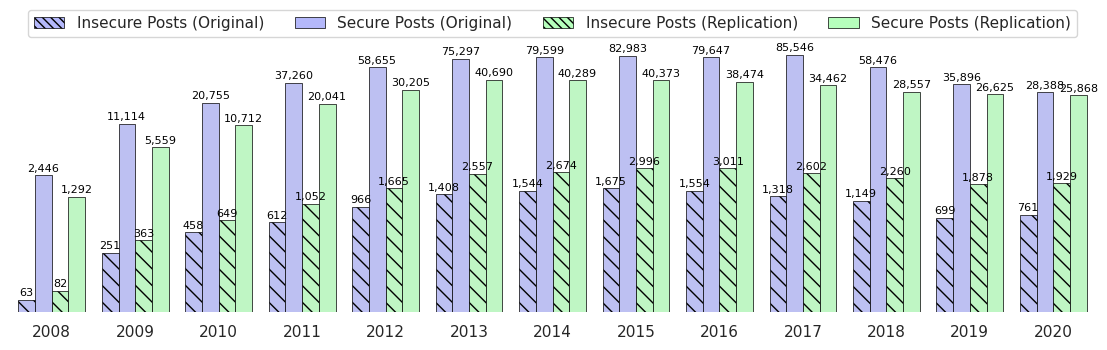

In [5]:
order = [  'insecure_orig', 'secure_orig', 'insecure', 'secure'  ]
# Sort the DataFrame by the 'Label' column
df_rq1['Label'] = pd.Categorical(df_rq1['Label'], categories=order, ordered=True)
df_rq1 = df_rq1.sort_values('Label')

plt.figure(figsize=(14, 3.5))
sns.set_palette(sns.color_palette(colors))

ax = sns.barplot(x='Year', y='Count', data=df_rq1, hue='Label')
sns.despine(left=True, bottom=True)
plt.grid(False)
plt.yscale('log')
plt.ylabel(None)
plt.xlabel(None)
plt.yticks([], [])
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')

# change order of the bars to be ['insecure', 'secure', 'insecure_orig', 'secure_orig']
ax.legend(title=None, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, handles=[insec_orig, sec_orig, insec, sec])

# Change legend entries
new_labels = [ 'Insecure Posts (Original)', 'Secure Posts (Original)','Insecure Posts (Replication)', 'Secure Posts (Replication)']
for t, l in zip(ax.get_legend().texts, new_labels): t.set_text(l)

for i, bar in enumerate(ax.patches):
    if i % df_rq1.Year.nunique() == 0:
        hatch = next(hatches)
    bar.set_hatch(hatch)
    bar.set_edgecolor('black')
    bar.set_linewidth(0.5)

plt.savefig('plots/dicos_RQ1.pdf', bbox_inches='tight')
plt.show()

In [6]:
# Pivot the DataFrame to have the years as columns
df_rq1_pivot = df_rq1.pivot(index="Year", columns="Label", values="Count").fillna(0)
display(df_rq1_pivot)

# Summing the total counts for each category
total_insecure_orig = df_rq1_pivot['insecure_orig'].sum()
total_secure_orig = df_rq1_pivot['secure_orig'].sum()
total_insecure = df_rq1_pivot['insecure'].sum()
total_secure = df_rq1_pivot['secure'].sum()

# Calculating the proportions
prop_insecure_orig = total_insecure_orig / (total_insecure_orig + total_secure_orig)
prop_insecure = total_insecure / (total_insecure + total_secure)

from statsmodels.stats.proportion import proportions_ztest

# Perform a two-sample z-test for proportions
count = np.array([total_insecure_orig, total_insecure])
nobs = np.array([total_insecure_orig + total_secure_orig, total_insecure + total_secure])

z_stat, p_val = proportions_ztest(count, nobs)

print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_val}")

Label,insecure_orig,secure_orig,insecure,secure
Year,,,,
2008,63,2446,82,1292
2009,251,11114,363,5559
2010,458,20755,649,10712
2011,612,37260,1052,20041
2012,966,58655,1665,30205
2013,1408,75297,2557,40690
2014,1544,79599,2674,40289
2015,1675,82983,2996,40373
2016,1554,79647,3011,38474


Z-statistic: -121.962130636817
P-value: 0.0


In [7]:
# Initialize a list to store z-test results for each year
ztest_results = []

# Number of years for Bonferroni correction (13 years)
num_years = df_rq1_pivot.shape[0]
alpha = 0.05  # Initial significance level

# Loop through each year and perform the z-test
for index, row in df_rq1_pivot.iterrows():
    # Count of insecure posts for each group (Original and other)
    count_year = np.array([row["insecure_orig"], row["insecure"]])
    # Total posts (insecure + secure) for each group
    nobs_year = np.array([row["insecure_orig"] + row["secure_orig"],
                          row["insecure"] + row["secure"]])

    # Perform two-proportion z-test for the current year
    z_stat_year, p_val_year = proportions_ztest(count_year, nobs_year)

    # Storing the result (year, z-statistic, p-value, adjusted significance level)
    ztest_results.append({
        "Year": row.index,
        "Z_Statistic": z_stat_year,
        "P_Value": p_val_year,
        "Significant (Bonferroni)": p_val_year < (alpha / num_years)
    })

# Applying Holm–Bonferroni correction
# Sorting the p-values in ascending order with their corresponding years and z-statistics
sorted_results = sorted(ztest_results, key=lambda x: x["P_Value"])

# Applying Holm-Bonferroni correction
m = len(sorted_results)  # Total number of tests (13 years)

for k, result in enumerate(sorted_results):
    adjusted_alpha = alpha / (m - k)  # Holm-Bonferroni correction step
    result["Adjusted Alpha (Holm-Bonferroni)"] = adjusted_alpha
    result["Significant (Holm-Bonferroni)"] = result["P_Value"] < adjusted_alpha

# Converting the sorted results back into a DataFrame for display
holm_bonferroni_df = pd.DataFrame(sorted_results)

# Displaying the results
print(holm_bonferroni_df)

                                                 Year  Z_Statistic  \
0   CategoricalIndex(['insecure_orig', 'secure_ori...   -37.922955   
1   CategoricalIndex(['insecure_orig', 'secure_ori...   -39.969349   
2   CategoricalIndex(['insecure_orig', 'secure_ori...   -44.524811   
3   CategoricalIndex(['insecure_orig', 'secure_ori...   -46.787370   
4   CategoricalIndex(['insecure_orig', 'secure_ori...   -50.679249   
5   CategoricalIndex(['insecure_orig', 'secure_ori...   -40.463258   
6   CategoricalIndex(['insecure_orig', 'secure_ori...   -31.078843   
7   CategoricalIndex(['insecure_orig', 'secure_ori...   -30.373403   
8   CategoricalIndex(['insecure_orig', 'secure_ori...   -24.339816   
9   CategoricalIndex(['insecure_orig', 'secure_ori...   -23.696631   
10  CategoricalIndex(['insecure_orig', 'secure_ori...   -16.869269   
11  CategoricalIndex(['insecure_orig', 'secure_ori...   -13.219080   
12  CategoricalIndex(['insecure_orig', 'secure_ori...    -5.432818   

          P_Value  

# RQ2

In [8]:
df_rq2 = pd.read_csv('data/dicos/RQ2.csv')
df_rq2

,Label,AcceptanceLabel,Count
0,Secure posts (Replication),Accepted posts,151289
1,Insecure posts (Replication),Accepted posts,11678
2,Secure posts (Replication),Non-accepted posts,235492
3,Insecure posts (Replication),Non-accepted posts,15566
4,Secure posts (Original),Accepted posts,270042
5,Insecure posts (Original),Accepted posts,4588
6,Secure posts (Original),Non-accepted posts,386020
7,Insecure posts (Original),Non-accepted posts,7870


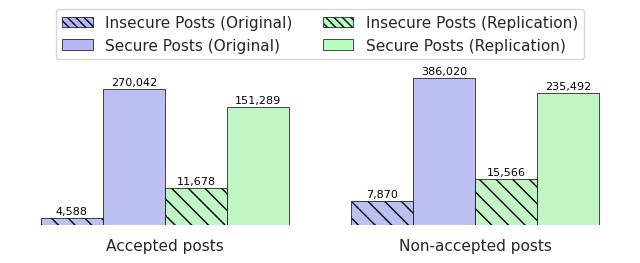

In [9]:
order = [  'Insecure posts (Original)', 'Secure posts (Original)', 'Insecure posts (Replication)', 'Secure posts (Replication)'  ]
# Sort the DataFrame by the 'Label' column
df_rq2['Label'] = pd.Categorical(df_rq2['Label'], categories=order, ordered=True)
df_rq2 = df_rq2.sort_values('Label')

plt.figure(figsize=(8, 2))
ax = sns.barplot(x='AcceptanceLabel', y='Count', data=df_rq2, hue='Label')
sns.despine(left=True, bottom=True)
plt.grid(False)
plt.yscale('log')
plt.ylabel(None)
plt.xlabel(None)
plt.yticks([], [])
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')

for i, bar in enumerate(ax.patches):
    if i  in [0, 1, 4, 5]:
        hatch = '\\\\'
    else:
        hatch = None
    bar.set_hatch(hatch)
    bar.set_edgecolor('black')
    bar.set_linewidth(0.5)


ax.legend(title=None, loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=2, handles=[insec_orig, sec_orig, insec, sec])

plt.savefig('plots/dicos_RQ2.pdf', bbox_inches='tight')
plt.show()

In [10]:
# Calculate total counts for each category
secure_replication = df_rq2[(df_rq2['Label'] == 'Secure posts (Replication)')]['Count'].sum()
insecure_replication = df_rq2[(df_rq2['Label'] == 'Insecure posts (Replication)')]['Count'].sum()
secure_original = df_rq2[(df_rq2['Label'] == 'Secure posts (Original)')]['Count'].sum()
insecure_original = df_rq2[(df_rq2['Label'] == 'Insecure posts (Original)')]['Count'].sum()

# Proportions
prop_secure_replication = secure_replication / (secure_replication + insecure_replication)
prop_insecure_replication = insecure_replication / (secure_replication + insecure_replication)
prop_secure_original = secure_original / (secure_original + insecure_original)
prop_insecure_original = insecure_original / (secure_original + insecure_original)

# Counts and observations
count = np.array([secure_replication, secure_original])
nobs = np.array([secure_replication + insecure_replication, secure_original + insecure_original])

# Perform the z-test for proportions
z_stat, p_val = proportions_ztest(count, nobs)

print(z_stat, p_val)

-126.8882899190951 0.0


In [11]:
from scipy.stats import chi2_contingency

# Create contingency tables
replication_table = pd.pivot_table(df_rq2[df_rq2['Label'].str.contains('Replication')],
                                   values='Count',
                                   index='Label',
                                   columns='AcceptanceLabel')

original_table = pd.pivot_table(df_rq2[df_rq2['Label'].str.contains('Original')],
                                values='Count',
                                index='Label',
                                columns='AcceptanceLabel')

# Perform chi-square test of independence
chi2_rep, p_rep, dof_rep, ex_rep = chi2_contingency(replication_table)
chi2_ori, p_ori, dof_ori, ex_ori = chi2_contingency(original_table)

# Print the results
print(f"Chi-square statistic for replication data: {chi2_rep}")
print(f"P-value for replication data: {p_rep}")
print(f"Chi-square statistic for original data: {chi2_ori}")
print(f"P-value for original data: {p_ori}")

Chi-square statistic for replication data: 149.76139234169946
P-value for replication data: 1.9548523260160954e-34
Chi-square statistic for original data: 94.66808073554526
P-value for original data: 2.2514041305156727e-22


/tmp/ipykernel_12311/154866378.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  replication_table = pd.pivot_table(df_rq2[df_rq2['Label'].str.contains('Replication')],
/tmp/ipykernel_12311/154866378.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  original_table = pd.pivot_table(df_rq2[df_rq2['Label'].str.contains('Original')],


# RQ3

In [12]:
df_rq3_data = pd.read_csv('data/dicos/RQ3.csv')
df_rq3_data


,PostId,Label,Description
0,55867406,1,Undefined behaviour
1,1966096,3,Memory leak
2,54616090,1,Undefined behaviour
3,20789277,1,Undefined behaviour
4,32219177,2,Null-terminated string issue
...,...,...,...
89,29577105,3,Memory leak
90,10741694,3,Memory leak
91,10614739,3,Memory leak
92,1621973,8,Others


In [13]:
# count frequencies of Desccription and create dataframe
df_rq3_rep = df_rq3_data['Description'].value_counts().reset_index()
df_rq3_rep.columns = ['Description', 'Count']
df_rq3_rep['Study'] = "Replication"
df_rq3_rep

,Description,Count,Study
0,Memory leak,43,Replication
1,Undefined behaviour,16,Replication
2,Others,15,Replication
3,Null-terminated string issue,10,Replication
4,Buffer overflow,6,Replication
5,Initialization issue,3,Replication
6,Infinite loop,1,Replication


In [14]:
# Add row with Decription "Out-of-bounds error" and Count 0 for Replication
df_rq3_rep = pd.concat([df_rq3_rep, pd.DataFrame({'Description': ['Out-of-bounds error'], 'Count': [0], 'Study': ['Replication']})], ignore_index=True)
df_rq3_rep

,Description,Count,Study
0,Memory leak,43,Replication
1,Undefined behaviour,16,Replication
2,Others,15,Replication
3,Null-terminated string issue,10,Replication
4,Buffer overflow,6,Replication
5,Initialization issue,3,Replication
6,Infinite loop,1,Replication
7,Out-of-bounds error,0,Replication


In [15]:
orig_data = {"Undefined behaviour":367, "Null-terminated string issue":175, "Memory leak": 91, "Buffer overflow":90, "Initialization issue":49, "Infinite loop":23, "Out-of-bounds error":17, "Others":68}
df_rq3_orig = pd.DataFrame(orig_data.items(), columns=['Description', 'Count'])
df_rq3_orig['Study'] = "Original"
df_rq3_orig

,Description,Count,Study
0,Undefined behaviour,367,Original
1,Null-terminated string issue,175,Original
2,Memory leak,91,Original
3,Buffer overflow,90,Original
4,Initialization issue,49,Original
5,Infinite loop,23,Original
6,Out-of-bounds error,17,Original
7,Others,68,Original


In [16]:
# Concatenate the two dataframes
df_rq3 = pd.concat([df_rq3_rep, df_rq3_orig])
df_rq3

,Description,Count,Study
0,Memory leak,43,Replication
1,Undefined behaviour,16,Replication
2,Others,15,Replication
3,Null-terminated string issue,10,Replication
4,Buffer overflow,6,Replication
5,Initialization issue,3,Replication
6,Infinite loop,1,Replication
7,Out-of-bounds error,0,Replication
0,Undefined behaviour,367,Original
1,Null-terminated string issue,175,Original


In [17]:
order = [  'Original', 'Replication'  ]
# Sort the DataFrame by the 'Study' column
df_rq3['Study'] = pd.Categorical(df_rq3['Study'], categories=order, ordered=True)
df_rq3 = df_rq3.sort_values('Study')

df_rq3

,Description,Count,Study
0,Undefined behaviour,367,Original
1,Null-terminated string issue,175,Original
2,Memory leak,91,Original
3,Buffer overflow,90,Original
4,Initialization issue,49,Original
5,Infinite loop,23,Original
6,Out-of-bounds error,17,Original
7,Others,68,Original
0,Memory leak,43,Replication
1,Undefined behaviour,16,Replication


/tmp/ipykernel_12311/3474637091.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


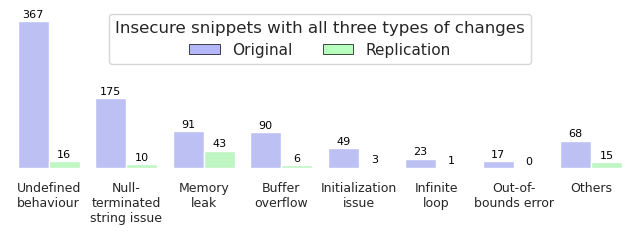

In [18]:
# Create a barplot

rep_handle  = mpatches.Patch( facecolor=colors[2], hatch=None,label='Replication', edgecolor='black', linewidth=0.5)
orig_handle = mpatches.Patch( facecolor=colors[0],hatch=None,label='Original', edgecolor='black', linewidth=0.5)

plt.figure(figsize=(8, 2))
ax = sns.barplot(x='Description', y='Count', data=df_rq3, hue='Study', palette=['#B4B8FB','#B6FFBC'])
sns.despine(left=True, bottom=True)
plt.grid(False)
# plt.yscale('log')
plt.ylabel(None)
plt.xlabel(None)
plt.yticks([], [])
for idx,p in enumerate(ax.patches):
    if idx > 15:
        continue
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')

ax.legend(title='Insecure snippets with all three types of changes', loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, handles=[orig_handle, rep_handle])

labels = ['Undefined\nbehaviour', 'Null-\nterminated\nstring issue', 'Memory\nleak', 'Buffer\noverflow', 'Initialization\nissue', 'Infinite\nloop', 'Out-of-\nbounds error', 'Others']
ax.set_xticklabels(labels)
plt.xticks(fontsize=9)

plt.savefig('plots/dicos_RQ3.pdf', bbox_inches='tight')
plt.show()

